In [1]:
import time
from datetime import datetime
from picamera import PiCamera
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import pickle
import os
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaFileUpload

gdfolder = '1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7'
num_pictures = 10

#######################################################
# GDrive authorization
#######################################################
creds = []
SCOPES = ['https://www.googleapis.com/auth/drive.file']
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

drive = build('drive', 'v3', credentials=creds)


In [2]:
######################################################
# motion file setup
######################################################
# grab list of files that already exist
results = drive.files().list(fields="files(id, name)", q="'1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7' in parents", orderBy='name').execute()['files']
gfiles = [results[ii]['id'] for ii in range(len(results)) if results[ii]['name'].startswith('motion')]

# make new placeholder files if necessary
for ii in range(len(gfiles), num_pictures):
    rc = cv2.imwrite('motion.jpg', (np.random.rand(200,300,3)*255).astype(int))
    media = MediaFileUpload('motion.jpg', mimetype='image/jpg')
    gfile = drive.files().create(body={'name': 'motion_%s.jpg' % str("{0:0=4d}".format(ii)), 'parents':[gdfolder]}, media_body=media, fields='id').execute()
    gfiles += [gfile]

In [147]:
##########################################
# configuration setup
##########################################
box = (190, 1280, 600, 775)
tdelay = 0.5  # seconds

# calibration
# need to measure and calibrate
# wag is 400 pixels = 50 ft
pixels_per_foot = 400.0/40.0
pixels_per_mile = pixels_per_foot * 5280.0
depth_adjust = 0.2  # %, cars going left to right are closer

# debug
debug = False

frameb = None
prev_cutout = None
prev_center = None
snapshot = np.empty((1024, 1280, 3), dtype=np.uint8)
gg = 0

start = time.time()

#fig, ax = plt.subplots(figsize=(14, 14))
#ax.imshow(background)


In [ ]:
#####################################################
# grab camera hardware and monitor
#####################################################
with PiCamera(resolution=(1280, 1024)) as camera:
    #camera.zoom = (box[0]/1280, box[2]/1024, box[1]/1280, box[3]/1024)
    time.sleep(2)
    try:
        while True:  #for ii in range(num_pictures):
            
            # take a picture
            time.sleep(tdelay)
            shot_time = time.time()
            camera.capture(snapshot, format='bgr', use_video_port=True)
            
            cutout = np.array(snapshot[box[2]:box[3], box[0]:box[1]])
            
            # compute the difference between the current frame and running average
            frame = cv2.cvtColor(cutout, cv2.COLOR_BGR2GRAY)
            frame = cv2.GaussianBlur(frame, (31, 31), 0)
            
            if frameb is None: frameb = np.array(frame)
            
            frameDelta = cv2.absdiff(frameb, frame)
            
            # threshold the delta image, dilate the thresholded image to fill in holes,
            # then find contours on thresholded image
            thresh = cv2.threshold(frameDelta, 30, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.dilate(thresh, None, iterations=8)
            rawcnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            rawcnts = imutils.grab_contours(rawcnts)
            areas = [cv2.contourArea(cc) for cc in rawcnts]
            
            # look for one large motion contour area
            if (len(areas) >= 1) and (areas[np.argmax(areas)] > 2000):
                cc = rawcnts[np.argmax(areas)]
                
                # compute the bounding box for the contour, draw it on the frame, and update the text
                (xx, yy, ww, hh) = cv2.boundingRect(cc)
                center = np.array([xx + ww//2, yy + hh//2])
                rc = cv2.rectangle(cutout, (xx, yy), (xx + ww, yy + hh), (0, 255, 0), 2)
            
                # if we had a large motion contour area in the previous frame as well
                if prev_center is not None:
                
                    # convert pixel distance to real world distance
                    distance = np.abs(center[0] - prev_center[0])             # in pixels
                    distance = distance / pixels_per_mile                     # in miles
                    speed = distance / ((shot_time-prev_shot_time)/3600)  # in miles per hour
                    
                    # adjust speed for cars in near lane (left to right)
                    if prev_center[0] < center[0]:
                        speed = speed * (1.0 - depth_adjust)
                
                    imtxt = datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '  ' + 'speed estimate = {:1.1f} mph'.format(speed)
                    print('motion detected in image ' + str(gg) + '...' + imtxt, end='\r')
                
                    # blend the snapshots and add space for text annotation
                    if debug:
                        print('')
                        print(shot_time-prev_shot_time)
                        two_frame = cv2.addWeighted(prev_cutout, 0.5, cutout, 0.5, 0.0)
                        two_frame = np.concatenate((np.tile(frameDelta[...,None],3), np.tile(thresh[...,None],3), two_frame, np.zeros((80,cutout.shape[1],3), dtype=int)+255), axis=0)
                    else:
                        two_frame = np.concatenate((prev_cutout, np.zeros((10,cutout.shape[1],3), dtype=int)+255, cutout, np.zeros((80,cutout.shape[1],3), dtype=int)+255), axis=0)
                
                    # only upload fast moving objects
                    if speed > 15.0:
                        cv2.putText(two_frame, imtxt, (10,two_frame.shape[0]-30), cv2.FONT_HERSHEY_DUPLEX, 1, 0)                
                        rc = cv2.imwrite('pictures/motion' + str(gg) + '.jpg', two_frame)               
                        media = MediaFileUpload('pictures/motion' + str(gg) + '.jpg', mimetype='image/jpg')
                        gfile = drive.files().update(fileId=gfiles[gg], media_body=media).execute()
                        gg = (gg + 1) % num_pictures
                
                # save this motion contour area for next frame comparison 
                prev_center = center
                prev_cutout = cutout
            
            # no large motion contour area
            else:
                prev_center = None
                prev_cutout = None
                frameb = np.array(frame)
            
            prev_shot_time = shot_time
                
    except KeyboardInterrupt:
        pass


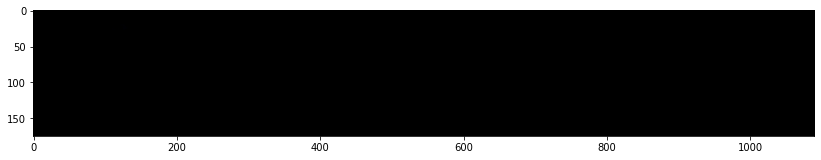

In [131]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(cutout)
#print(np.min(two_frame), np.max(two_frame), np.mean(two_frame))